In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/StellarStreams')

import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import Config
import BalrogTestConfig as balrConfig
matplotlib.style.use('des_dr1')

In [2]:
cutOffPercent = .01
res = 4096
binNum = 10

In [3]:
allPixFile = balrConfig.test1aAllPixFile
galaFile = balrConfig.test1aGalaFile
validPixFile = balrConfig.test1aValidPixFile
condFiles = balrConfig.test1aCondFiles

In [4]:
injData = fitsio.read(allPixFile)

In [5]:
injPix = hp.ang2pix(res, injData['RA'], injData['DEC'], nest = True, lonlat = True)
validPix = np.unique(injPix)

In [6]:
detData = fitsio.read(galaFile)

In [7]:
detPix = hp.ang2pix(res, detData['RA'], detData['DEC'], nest = True, lonlat = True)

In [8]:
_, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
origDetPixCounts = origDetPixCounts - 1

In [9]:
condFiles = balrConfig.test1aCondFiles

condMaps = []

# This loops over every condition file
for condFile in condFiles:
    condData = fitsio.read(condFile) # This reads in the data
    condMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

condMaps = np.array(condMaps)

In [10]:
aveDet = np.sum(origDetPixCounts) / len(origDetPixCounts)

In [11]:
errorsFile = balrConfig.test1aDir + '80_Test_Errors_' + str(cutOffPercent) + '.fits'
detPixFile = balrConfig.test1aDir + '80_Test_Pix_Counts_' + str(cutOffPercent) + '.fits'
trainIndsFile = balrConfig.test1aDir + '80_Test_Train_Inds_' + str(cutOffPercent) + '.fits'

In [12]:
allErrors = fitsio.read(errorsFile)['Errors']
detPixCounts = fitsio.read(detPixFile)['Counts']
trainInds = fitsio.read(trainIndsFile)['Inds']

In [13]:
conditions = Config.conditions

# 1D Plots

In [14]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [15]:
condMaxErrors = []

for condInd in np.arange(len(conditions)):#[10]:#[77]:
    
    condition = conditions[condInd]
    
    condMap = condMaps[condInd]
    condSortInds = condMap[~trainInds].argsort()
    
    condSort = condMap[~trainInds][condSortInds[::1]]
    detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]
    origDetStarTemp = origDetPixCounts[~trainInds][condSortInds[::1]]

    origDetBins = []
    detBins = []
    condBins = []

    for j in range(10):
        origDetBins.append(origDetStarTemp[binIndLims[j]:binIndLims[j+1]])
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        condBins.append(condSort[binIndLims[j]:binIndLims[j+1]])

    yBinCondOrig = []
    yBinCond = []
    xBinCond = []

    for j in range(10):
        yBinCondOrig.append(np.sum(origDetBins[j]) / (aveDet * len(origDetBins[j])))
        yBinCond.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
        xBinCond.append(np.sum(condBins[j]) / len(condBins[j]))

    xBinCond = np.array(xBinCond)
    yBinCond = np.array(yBinCond)
    yBinCondOrig = np.array(yBinCondOrig)
    
    condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
    
#     fig, ax1 = plt.subplots()

#     # Major ticks every 20, minor ticks every 5
#     major_ticks = np.arange(0, 2, 0.02)
#     minor_ticks = np.arange(0, 2, 0.01)

#     ax1.set_yticks(major_ticks)
#     ax1.set_yticks(minor_ticks, minor=True)

#     ax1.set_xlabel(condition)
#     ax1.tick_params(axis='y')
#     ax1.set_ylabel(r'Variation from Mean Rate')
#     ax1.plot(xBinCond, yBinCondOrig, label = 'Original, ' + r'$\sigma = $' + str(np.round(np.std(yBinCondOrig), decimals = 3)), marker = 'o')
#     ax1.plot(xBinCond, yBinCond, label = 'Corrected, ' + r'$\sigma = $' + str(np.round(np.std(yBinCond), decimals = 3)), marker = 'o')
#     ax1.axhline(y = 1, color = 'black', linestyle = '--')
#     # And a corresponding grid
#     ax1.grid(which='both')

#     # Or if you want different settings for the grids:
#     ax1.grid(which='minor', alpha=0.2)
#     ax1.grid(which='major', alpha=0.5)
#     # ax1.grid()
#     ax1.legend()

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     ax2.tick_params(axis='y')
#     ax2.set_ylabel('Fraction of Pixels in Condition Bin')
#     ax2.hist(condSort, bins = np.linspace(np.min(xBinCond), np.max(xBinCond), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condSort)) / len(condSort))

#     ax3 = ax1.twinx()
#     ax3.tick_params(axis='y', right = False, labelright = False)
#     ax3.plot(xBinCond, yBinCondOrig, marker = 'o')
#     ax3.plot(xBinCond, yBinCond, marker = 'o')
#     ax3.axhline(y = 1, color = 'black', linestyle = '--')


#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.title('Galaxy Detection Rate Variations')
#     # plt.show()
#     plt.savefig('Bad Galaxy Detection')

In [16]:
np.average(condMaxErrors)

0.006573989721044628

# 2D Plots

In [17]:
metricFile = balrConfig.test1aDir + '2D_Metrics_' + str(cutOffPercent) + '.fits'

In [18]:
metricData = fitsio.read(metricFile)

In [19]:
allMetrics = metricData['Metric']
allMetricWeights = metricData['Weight']

In [20]:
np.min(allMetrics)

0.6695380011061245

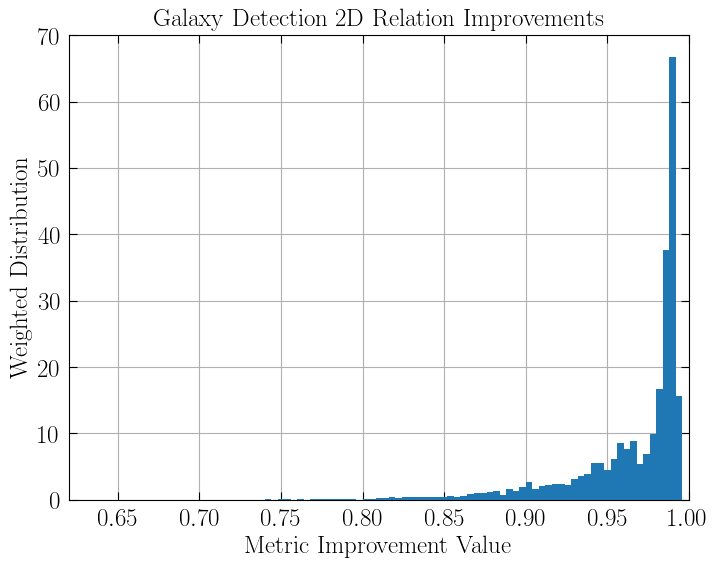

In [21]:
plt.figure()
plt.hist(allMetrics, bins = np.linspace(0.6, 1, 101), weights = allMetricWeights, zorder = 3, density = True)
plt.xlabel('Metric Improvement Value')
plt.ylabel('Weighted Distribution')
plt.title('Galaxy Detection 2D Relation Improvements')
plt.grid(zorder = 0)
plt.xlim([0.62, 1])
# plt.yscale('log')
plt.savefig('2D Metric Galaxy')

In [64]:
index_one = 37
index_two = 75

In [65]:
condSortInds = condMaps[index_one][~trainInds].argsort()
sortedFirst = condMaps[index_one][~trainInds][condSortInds[::1]]
first_bin_lims = []
for i in range(binNum):
    first_bin_lims.append(sortedFirst[binIndLims[i]])
first_bin_lims.append(sortedFirst[-1])

condSortInds = condMaps[index_two][~trainInds].argsort()
sortedSecond = condMaps[index_two][~trainInds][condSortInds[::1]]
second_bin_lims = []
for i in range(binNum):
    second_bin_lims.append(sortedSecond[binIndLims[i]])
second_bin_lims.append(sortedSecond[-1])

# sortedFirst = condMaps[index_one][sortInds[index_one][::1]]
# first_bin_lims = []
# for i in range(binNum):
#     first_bin_lims.append(sortedFirst[binIndLims[i]])
# first_bin_lims.append(sortedFirst[-1])

# sortedSecond = condMaps[index_two][sortInds[index_two][::1]]
# second_bin_lims = []
# for i in range(binNum):
#     second_bin_lims.append(sortedSecond[binIndLims[i]])
# second_bin_lims.append(sortedSecond[-1])

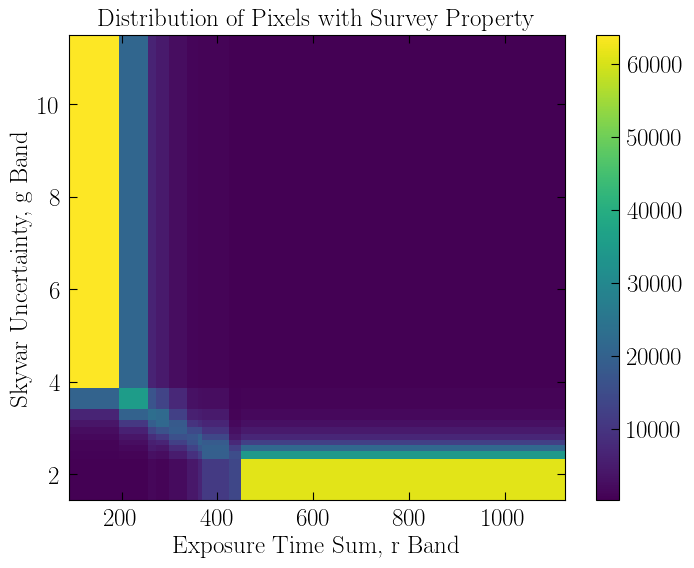

In [66]:
plt.figure()
bins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims))
countBins = bins[0]
plt.xlabel(conditions[index_one])
plt.ylabel(conditions[index_two])
plt.title('Distribution of Pixels with Survey Property')
plt.colorbar()
plt.show()

In [67]:
normWeights = np.ones_like(condMaps[index_one][~trainInds])
for i in np.arange(len(first_bin_lims) - 1):
    for j in np.arange(len(second_bin_lims) - 1):
        inds = np.where((condMaps[index_one][~trainInds] <= first_bin_lims[i + 1]) & (condMaps[index_one][~trainInds] >= first_bin_lims[i]) & (condMaps[index_two][~trainInds] <= second_bin_lims[j + 1]) & (condMaps[index_two][~trainInds] >= second_bin_lims[j]))[0]
        if countBins[i][j] != 0:
            normWeights[inds] = 1 / (countBins[i][j])

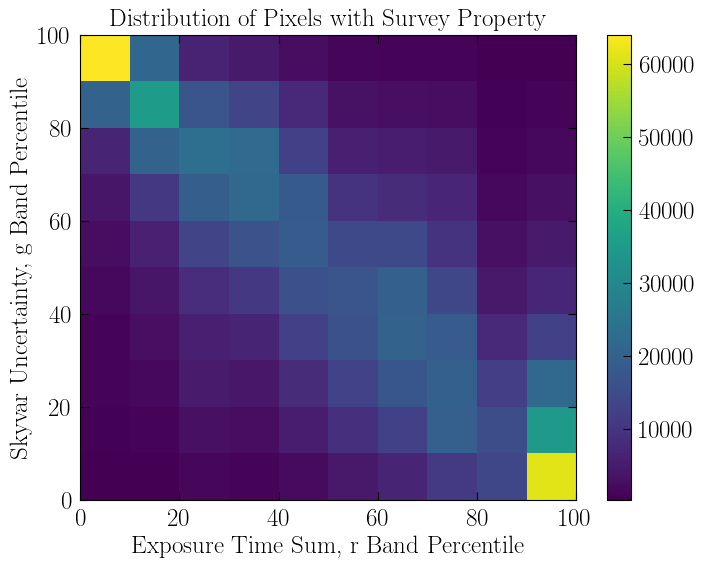

In [68]:
xHist = np.linspace(0, 100, 10)
yHist = np.linspace(0, 100, 10)
mesh = np.meshgrid(xHist, yHist)
xHist = mesh[0].flatten()
yHist = mesh[1].flatten()
pixCountBins = (countBins.T).flatten()

plt.figure()
origCountBins = plt.hist2d(xHist, yHist, weights = pixCountBins)
origCountBins = origCountBins[0].flatten()
plt.xlabel(conditions[index_one] + ' Percentile')
plt.ylabel(conditions[index_two] + ' Percentile')
plt.title('Distribution of Pixels with Survey Property')
plt.colorbar()
plt.savefig('2D Pixel')

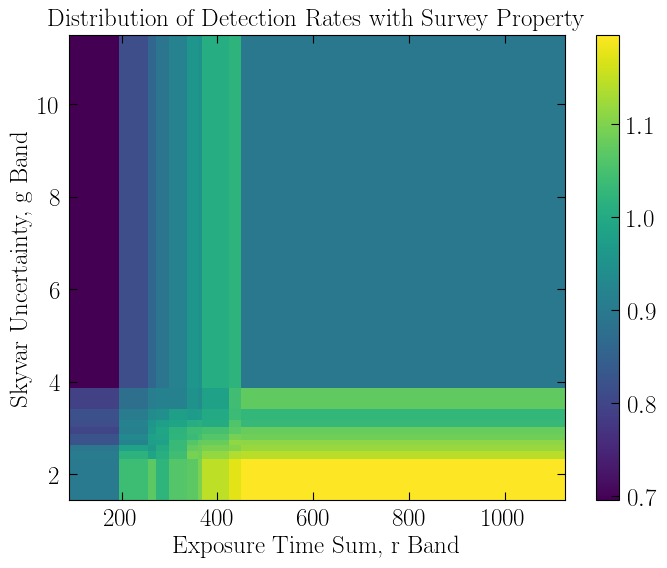

In [69]:
plt.figure()
countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = origDetPixCounts[~trainInds] * normWeights / aveDet)
countBins = countBins[0]
plt.xlabel(conditions[index_one])
plt.ylabel(conditions[index_two])
plt.title('Distribution of Detection Rates with Survey Property')
plt.colorbar()
plt.show()

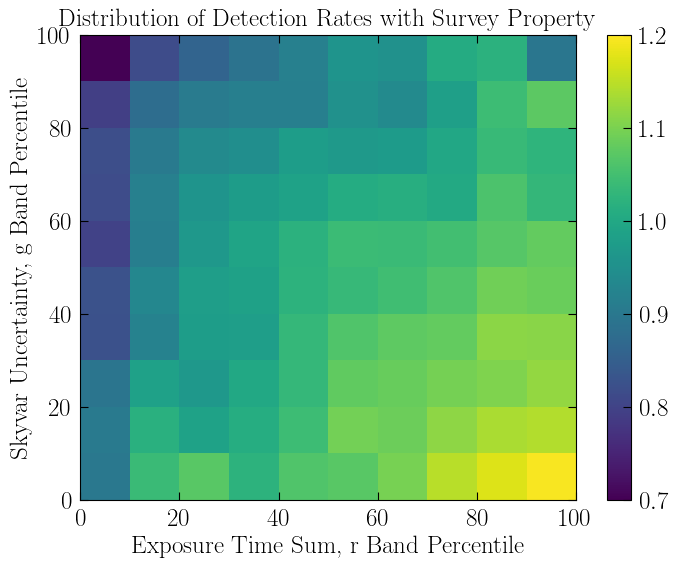

In [70]:
xHist = np.linspace(0, 100, 10)
yHist = np.linspace(0, 100, 10)
mesh = np.meshgrid(xHist, yHist)
xHist = mesh[0].flatten()
yHist = mesh[1].flatten()
countBinsOrig = (countBins.T).flatten()

plt.figure()
origCountBins = plt.hist2d(xHist, yHist, weights = countBinsOrig, vmin = 0.7, vmax = 1.2)
origCountBins = (origCountBins[0].T).flatten()
plt.xlabel(conditions[index_one] + ' Percentile')
plt.ylabel(conditions[index_two] + ' Percentile')
plt.title('Distribution of Detection Rates with Survey Property')
plt.colorbar()
plt.savefig('2D Original')

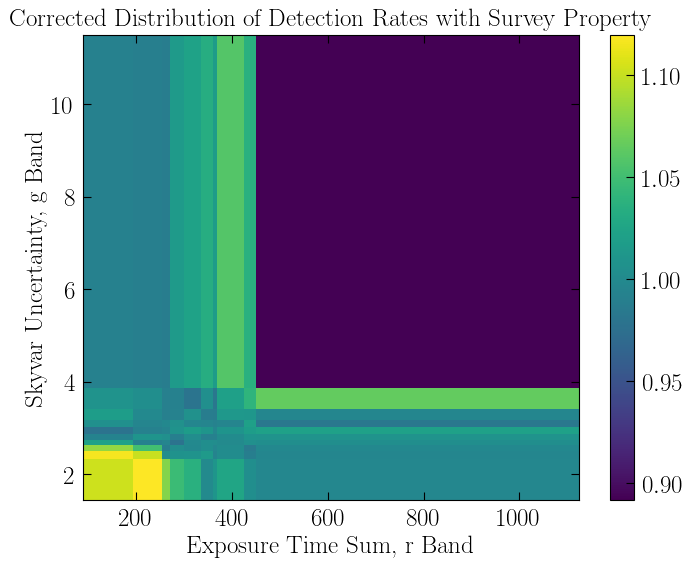

In [71]:
plt.figure()
countBins = plt.hist2d(condMaps[index_one][~trainInds], condMaps[index_two][~trainInds], bins = (first_bin_lims, second_bin_lims), weights = detPixCounts[~trainInds] * normWeights / aveDet)
countBins = countBins[0]
plt.xlabel(conditions[index_one])
plt.ylabel(conditions[index_two])
plt.title('Corrected Distribution of Detection Rates with Survey Property')
plt.colorbar()
plt.show()

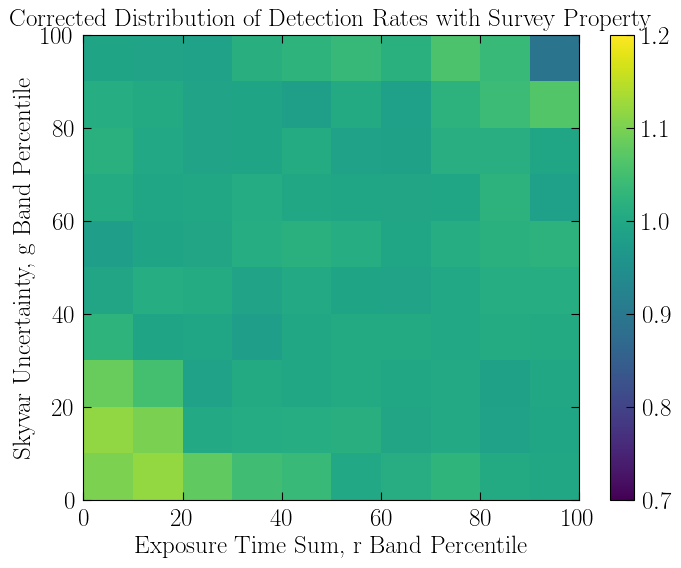

In [72]:
xHist = np.linspace(0, 100, 10)
yHist = np.linspace(0, 100, 10)
mesh = np.meshgrid(xHist, yHist)
xHist = mesh[0].flatten()
yHist = mesh[1].flatten()
countBinsCorr = (countBins.T).flatten()

plt.figure()
corrCountBins = plt.hist2d(xHist, yHist, weights = countBinsCorr, vmin = 0.7, vmax = 1.2)
corrCountBins = (corrCountBins[0].T).flatten()
plt.xlabel(conditions[index_one] + ' Percentile')
plt.ylabel(conditions[index_two] + ' Percentile')
plt.title('Corrected Distribution of Detection Rates with Survey Property')
plt.colorbar()
plt.savefig('2D Corrected')

In [73]:
metric = 1 - (np.sum(pixCountBins * ((corrCountBins - 1)**2)) / np.sum(pixCountBins * ((origCountBins - 1)**2)))
weight = np.sum(pixCountBins * ((origCountBins - 1)**2)) / np.sum(pixCountBins)

In [74]:
metric

0.9913479570769733

In [75]:
weight

0.015600784691169493

In [76]:
np.average(allMetricWeights)

0.007246499452275849

In [77]:
# fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True)
# det_arr = [pixCountBins, countBinsOrig, countBinsCorr]
# vmin_arr = [0, 0.7, 0.7]
# vmax_arr = [65000, 1.2, 1.2]
# titles = ['Separable Original', 'Inseparable Original', 'Separable Corrected', 'Inseparable Corrected']
# for j in range(len(det_arr)):
#     im = axs[j].hist2d(xHist, yHist, weights = det_arr[j], vmin = vmin_arr[j], vmax = vmax_arr[j])
#     #if j%2 == 1:
#     axs[j].set_title(titles[j])
#     fig.colorbar(im[3], ax = axs[j])
    
# # fig.supxlabel('X Survey Property Percentile')
# # fig.supylabel('Y Survey Property Percentile')
# # fig.suptitle('Separability Simulated Tests')
# plt.show()